In [135]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import math
import numba as nb
from testing_sample import *
import numpy as np


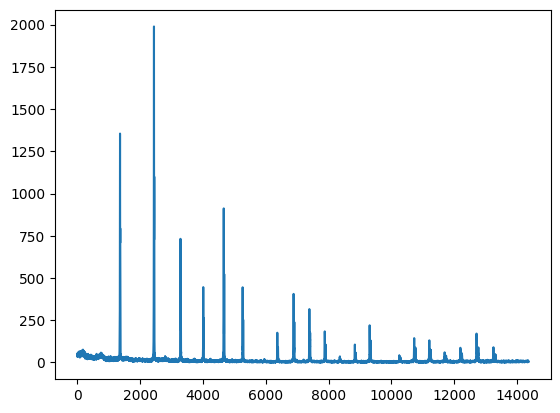

In [136]:
#create class element - aparature
ap = Data_file(-1)
plt.plot(ap.counts)

In [137]:
corr_ap_counts,x_corr_ap_counts = [],[]
for i in range(len(ap.counts)):
    if ap.counts[i]>20:
        corr_ap_counts.append(ap.counts[i])
        x_corr_ap_counts.append(ap.x[i])
        
nr_of_step = len(corr_ap_counts)
# x_counts_above_40 = np.linspace(ap.theta_start, ap.theta_stop, nr_of_step)
if nr_of_step > 1:
    step = (ap.theta_stop - ap.theta_start) / (nr_of_step - 1)
else:
    step = 0.0

In [138]:
def pseudo_voigt(x, A, x0, sigma, gamma, eta):
    G = np.exp(-(x - x0)**2 / (2 * sigma**2))
    L = gamma**2 / ((x - x0)**2 + gamma**2)
    return A * (eta * L + (1 - eta) * G)
def rr2_pv(x, y, A, x0, sigma, gamma, eta):
    y_fit = pseudo_voigt(x, A, x0, sigma, gamma, eta)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot

In [139]:
# def peak_detect_ap(counts, x, heigh, dist, prom,theta_start, step, eps = 4, plotting=False,fitting = False,fit_range = 10):
#     ''' If fitting = False - function return values:
#     len(peaks),len(correct_peaks)/len(two_theta),heigh,dist,prom ;
#     If fitting = True - function return values:
#     peaks,correct_peaks,index_corrected,gauss_fit,_  '''
#     peaks, _ = find_peaks(counts)#, height=heigh, distance=dist, prominence=prom)
#     if len(peaks) == 0:
#         print(" Nie znaleziono pików - spróbuj obniżyć progu 'height' lub 'prominence'.")
#         return False
#     fitted_params,r2_list,gauss_fit,peak_corr  = [],[],[],[]  # (A, x0, sigma) dla każdego dopasowanego piku
#     for pk in peaks:
#         # ogranicz dane do małego okna wokół piku
#         left = max(0, pk - fit_range)
#         right = min(len(x), pk + fit_range)
#         x_fit = x[left:right]
#         y_fit = counts[left:right]
#         A_guess = counts[pk]
#         x0_guess = x[pk]
#         sigma_guess = 1.0
#         try:
#             popt, _ = curve_fit(
#                 pseudo_voigt, x_fit, y_fit,
#                 p0=[A_guess, x0_guess, 1.0, 1.0, 0.3],  # A, x0, sigma, gamma, eta
#                 bounds=(
#                     [0.0, x0_guess - 5.0, 0.01, 0.01, 0.0],
#                     [np.max(counts) * 5, x0_guess + 5.0, 10.0, 10.0, 1.0]
#                     )
#             )
#             fitted_params.append(popt)
#             # A_fit, x0_fit, sigma_fit = popt
#             # oblicz R² lokalnie
#             gauss_fit.append(popt)
#             # r2_list.append(rr2(
#             #     np.asarray(x_fit, dtype=np.float64),
#             #     np.asarray(y_fit, dtype=np.float64),
#             #     np.float64(A_fit),
#             #     np.float64(x0_fit),
#             #     np.float64(sigma_fit)
#             # ))
#             r2_list.append(rr2_pv(
#                 np.asarray(x_fit, dtype=np.float64),
#                 np.asarray(y_fit, dtype=np.float64),
#                 *popt
#             ))
#             peak_corr.append(peaks[pk])
#         except RuntimeError:
#             fitted_params.append((np.nan, np.nan, np.nan))
#             r2_list.append(np.nan)
#             # print(fr"nie ma {pk}")
#     # if plotting == True:
#     #     plot_gauss(correct_peaks,peaks, counts, x, two_theta,30)
#     return len(peak_corr),peak_corr,heigh,dist,prom,gauss_fit


In [140]:
def finding_fwhm(peaks,gauss_fit):
    '''in order - A, mu,sigma '''
    N = len(peaks)
    fwhm = np.zeros(N)
    t_fwhm = np.zeros(N)
    for j in range(len(peaks)):
        fwhm[j] = 2 * gauss_fit[j][2]* math.sqrt(2 * math.log(2))
        t_fwhm[j] = gauss_fit[j][1]
    return fwhm,t_fwhm

In [141]:
# # len_peaks,peaks,heigh,dist,prom,gauss_fit = peak_detect_ap(corr_ap_counts,x_corr_ap_counts,0,0,0,ap.theta_start,step)
# len_peaks,peaks,heigh,dist,prom,gauss_fit = peak_detect_ap(ap.counts,ap.x,0,0,0,ap.theta_start,ap.step)

In [142]:
# print(gauss_fit)
# print(len(gauss_fit))
# print(len_peaks)

In [143]:
# fwhm,t_fwhm = finding_fwhm(peaks,gauss_fit)

In [144]:
def plot_gauss_ap(peaks,count,x,segment_width = 15,two_theta = None):
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        plt.plot(ap.x, ap.counts, label='Dane (po baseline)', alpha=0.6, color = "pink")
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        plt.xlim(seg_start, seg_end)
        # plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        if two_theta is not None:
            for i in range(len(two_theta)):
                plt.axvline(two_theta[i], color='red', linestyle='--', linewidth=0.5)
        plt.ylim(0, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()

In [145]:
# plot_gauss_ap(peaks,ap.counts,ap.x,segment_width=5)


In [146]:
# plot_gauss_ap(peaks,np.asarray(corr_ap_counts),np.asarray(x_corr_ap_counts),segment_width=5)

In [147]:
# from scipy.signal import find_peaks, savgol_filter

# def detect_xrd_peaks(counts, x,
#                      smoothing_window = 21,
#                      polyorder = 3,
#                      min_prom = 20,
#                      min_width = 3,
#                      min_distance = None,
#                      plotting=False):

#     # 1. Wygładzanie widma
#     smoothed = savgol_filter(counts, smoothing_window, polyorder)

#     # 2. Ustawienie minimalnego dystansu między pikami
#     if min_distance is None:
#         min_distance = int(len(counts) * 0.002)  # ok. 0.2% zakresu

#     # 3. Detekcja pików
#     peaks, props = find_peaks(
#         smoothed,
#         prominence=min_prom,
#         width=min_width,
#         distance=min_distance
#     )
#     fit_range = 10
#     fitted_params,r2_list,gauss_fit  = [],[],[]  # (A, x0, sigma) dla każdego dopasowanego piku
#     for pk in peaks:
#         # ogranicz dane do małego okna wokół piku
#         left = max(0, pk - fit_range)
#         right = min(len(x), pk + fit_range)
#         x_fit = x[left:right]
#         y_fit = counts[left:right]
#         A_guess = counts[pk]
#         x0_guess = x[pk]
#         sigma_guess = 1.0
#         try:
#             popt, _ = curve_fit(
#                 gaussian, x_fit, y_fit,
#                 p0=[A_guess, x0_guess, sigma_guess],
#                 bounds=([0.0, x0_guess - 5.0, 0.01],
#                         [np.max(counts) * 5, x0_guess + 5.0, 10.0])
#             )
#             fitted_params.append(popt)
#             A_fit, x0_fit, sigma_fit = popt
#             # oblicz R² lokalnie
#             gauss_fit.append([A_fit, x0_fit, sigma_fit])
#             r2_list.append(rr2(
#                 np.asarray(x_fit, dtype=np.float64),
#                 np.asarray(y_fit, dtype=np.float64),
#                 np.float64(A_fit),
#                 np.float64(x0_fit),
#                 np.float64(sigma_fit)
#             ))
#         except RuntimeError:
#             fitted_params.append((np.nan, np.nan, np.nan))
#             r2_list.append(np.nan)
#     if plotting:
#         plt.figure(figsize=(8,5))
#         plt.plot(x, smoothed, label='Wygładzone dane')
#         plt.scatter(x[peaks], smoothed[peaks], color='red', s=30, label='Piki')
#         plt.plot(x, counts, alpha=0.3, color='gray', label='Surowe dane')
#         plt.legend()
#         plt.show()

#     return peaks, smoothed,gauss_fit


In [148]:
# peaks, smoothed ,gauss_fit= detect_xrd_peaks(
#     np.asarray(corr_ap_counts),
#     np.asarray(x_corr_ap_counts),
#     smoothing_window=8,   # szersze wygładzenie
#     min_prom=10,           # wymagaj 30 jednostek amplitudy nad szumem
#     min_width=2,           # minimalna szerokość piku
#     plotting=True
# )


In [149]:
# plot_gauss_ap(peaks,np.asarray(corr_ap_counts),np.asarray(x_corr_ap_counts),segment_width=5)

In [150]:
# print(gauss_fit)
# print(len(gauss_fit))

In [151]:
def finding_fwhm(peaks,gauss_fit):
    '''in order - A, mu,sigma '''
    N = len(peaks)
    fwhm = np.zeros(N)
    t_fwhm = np.zeros(N)
    for j in range(len(peaks)):
        fwhm[j] = 2 * gauss_fit[j][2]* math.sqrt(2 * math.log(2))
        t_fwhm[j] = gauss_fit[j][1]
    return fwhm,t_fwhm

In [152]:
# fwhm,t_fwhm = finding_fwhm(peaks,gauss_fit)

In [153]:
# plt.scatter(t_fwhm,fwhm)

In [154]:
# def finding_fwhm_plot(counts,x,gauss_fit,theta_start,step,plotting = True):
#     '''in order - A, mu,sigma '''
#     N = len(index_corrected)
#     fwhm = np.zeros(N)
#     t_fwhm = np.zeros(N)
#     diff = np.zeros(N)
#     for j in range(len(index_corrected)):
#         if plotting == True:
#             plt.scatter(x, counts, s=10, label="dane")
#             plt.plot(x, gaussian(x, *gauss_fit[index_corrected[j]]), label="dopasowany Gauss", linewidth=2,color = 'red')
#             plt.axvline(gauss_fit[index_corrected[j]][1])
#             plt.legend()
#             plt.xlim(gauss_fit[index_corrected[j]][1]-gauss_fit[index_corrected[j]][2]-1,gauss_fit[index_corrected[j]][1]+gauss_fit[index_corrected[j]][2]+1)
#             plt.ylim(0,gauss_fit[index_corrected[j]][0]+100)
#             plt.axhline(gauss_fit[index_corrected[j]][0]/2, color='r', linestyle='--', label='Pozioma linia')
#         max_index = int((gauss_fit[index_corrected[j]][1]-theta_start)/step )
#         if max_index>len(counts):
#             max_index = len(counts)
            
#         if max_index - 20 <= 0:
#             min = abs(counts[0]-(gauss_fit[index_corrected[j]][0]/2))
#             l_ind = 0
#             left_max_ind = 0
#         else:
#             min = abs(counts[max_index - 20]-(gauss_fit[index_corrected[j]][0]/2))
#             l_ind = max_index - 20
#             left_max_ind = max_index - 20
#         if max_index == len(counts):
#             min2 = abs(counts[-1]-(gauss_fit[index_corrected[j]][0]/2))
#             r_ind = max_index
#         else:
#             min2 = abs(counts[max_index]-(gauss_fit[index_corrected[j]][0]/2))
#             r_ind = max_index
    
#         for i in range(left_max_ind,max_index):
#             if abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))<min:
#                 min=abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))
#                 l_ind = i
#         if max_index+20>=len(counts):
#             right_max_ind = len(counts)
#         else:
#             right_max_ind = max_index+20
#         for i in range(max_index,right_max_ind):
#             if abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))<min2:
#                 min2=abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))
#                 r_ind = i
#         if plotting == True:
#             dd = [x[l_ind],x[r_ind]]
#             kk = [counts[l_ind],counts[r_ind]]
#             plt.scatter(dd,kk,color ='green')
#             plt.show()
#         diff[j] = (r_ind - l_ind) * step
#         fwhm[j] = 2 * gauss_fit[index_corrected[j]][2] * math.sqrt(2 * math.log(2))
#         t_fwhm[j] = gauss_fit[index_corrected[j]][1]
#     return fwhm,t_fwhm,diff

In [155]:
def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))
def gaussian_bg(x, A, x0, sigma, c):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c
def gaussian_asym(x, A, x0, sigma_l, sigma_r):
    return np.where(
        x < x0,
        A * np.exp(-(x - x0)**2 / (2 * sigma_l**2)),
        A * np.exp(-(x - x0)**2 / (2 * sigma_r**2))
    )
def lorentzian(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))
def gauss_lorentz(x, A, x0, sigma, gamma):
    return (
        A * np.exp(-(x - x0)**2 / (2 * sigma**2)) +
        A * (gamma**2 / ((x - x0)**2 + gamma**2))
    )
def pseudo_voigt(x, A, x0, sigma, gamma, eta):
    G = np.exp(-(x - x0)**2 / (2 * sigma**2))
    L = gamma**2 / ((x - x0)**2 + gamma**2)
    return A * (eta * L + (1 - eta) * G)
def rr2_pv(x, y, A, x0, sigma, gamma, eta):
    y_fit = pseudo_voigt(x, A, x0, sigma, gamma, eta)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot

def pseudo_voigt_bg(x, A, x0, sigma, gamma, eta, c):
    return pseudo_voigt(x, A, x0, sigma, gamma, eta) + c
def pseudo_voigt_bg_lin(x, A, x0, sigma, gamma, eta, a, b):
    return pseudo_voigt(x, A, x0, sigma, gamma, eta) + a*x + b


def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        A, x0, sigma = params[i:i+3]
        y += gaussian(x, A, x0, sigma)
    return y

def rr2(x, y, A, x0, sigma):
    y_fit = gaussian(x, A, x0, sigma)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

def rr2_weighted(x, y, A, x0, sigma):
    y_fit = gaussian(x, A, x0, sigma)
    w = 1 / np.maximum(y, 1)
    ss_res = np.sum(w * (y - y_fit)**2)
    ss_tot = np.sum(w * (y - np.mean(y))**2)
    return 1 - ss_res / ss_tot
def rr2_pv(x, y, A, x0, sigma, gamma, eta):
    y_fit = pseudo_voigt(x, A, x0, sigma, gamma, eta)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot


In [156]:
def peak_detect_simple(counts, height=None, dist=None, prom=None):
    peaks, props = find_peaks(
        counts,
        height=height,
        distance=dist,
        prominence=prom
    )
    return peaks, props


In [157]:
def peak_detect_with_quality(counts, x, r2_min=0.9, fit_range=10):
    peaks, _ = find_peaks(counts)
    good_peaks = []
    gauss_fit = []
    for pk in peaks:
        l = max(0, pk - fit_range)
        r = min(len(x), pk + fit_range)

        try:
            popt, _ = curve_fit(
                gaussian,
                x[l:r],
                counts[l:r],
                p0=[counts[pk], x[pk], 1.0]
            )
            r2 = rr2(x[l:r], counts[l:r], *popt)
            if r2 > r2_min:
                good_peaks.append(pk)
                gauss_fit.append(popt)
        except RuntimeError:
            pass

    return np.array(good_peaks),gauss_fit


In [158]:
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

def peak_detect_gauss_quality(
    counts,
    x,
    r2_min=0.9,
    fit_range=10,
    height=None,
    distance=None,
    prominence=None
):
    """
    Peak detection + Gaussian fitting with R² quality filter.

    Returns:
        good_peaks : np.ndarray (indices)
        gauss_fit  : list of fitted parameters [A, mu, sigma]
        r2_list    : list of R² values
    """

    peaks, _ = find_peaks(
        counts,
        height=height,
        distance=distance,
        prominence=prominence
    )

    if len(peaks) == 0:
        return np.array([]), [], []

    good_peaks = []
    gauss_fit = []
    r2_list = []

    for pk in peaks:

        # local window
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)

        x_fit = x[left:right]
        y_fit = counts[left:right]

        # initial guesses
        A0 = counts[pk]
        mu0 = x[pk]
        sigma0 = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1.0

        try:
            popt, _ = curve_fit(
                gaussian,
                x_fit,
                y_fit,
                p0=[A0, mu0, sigma0],
                bounds=(
                    [0.0, mu0 - fit_range, 1e-3],
                    [np.inf, mu0 + fit_range, np.inf]
                )
            )

            r2 = rr2(x_fit, y_fit, *popt)

            if r2 >= r2_min:
                good_peaks.append(pk)
                gauss_fit.append(popt)
                r2_list.append(r2)

        except RuntimeError:
            continue

    return np.array(good_peaks), gauss_fit, r2_list


In [159]:
f= Data_file(0)
f.read_data_of_hkl()

In [160]:
ap_good_peaks,ap_gauss_fit,_ = peak_detect_gauss_quality(ap.counts,ap.x,r2_min=0.6)

In [161]:
# ap_good_peaks,ap_gauss_fit = peak_detect_with_quality(ap.counts,ap.x,r2_min=0.4)


In [162]:
good_peaks,gauss_fit = peak_detect_with_quality(f.counts,f.x,r2_min=0.6)


In [163]:
print(good_peaks)
print(len(good_peaks))

[  99  451  459  570  612  654  657  659  663  840  843 1147 1149 1152
 1155 1231 1254 1256 1397 1418 1423 1425 1667 1670 1672 1681 1684 1757
 1760 1764 1767 1773 1798 1801 1804 1923 1927 1930 2140 2145 2213 2215
 2231 2236 2239 2241 2243 2245 2363 2370 2374 2376 2381 2383 2386 2398
 2694 2742 2834]
59



Tworzę 8 wykresów (co 15° 2θ)...


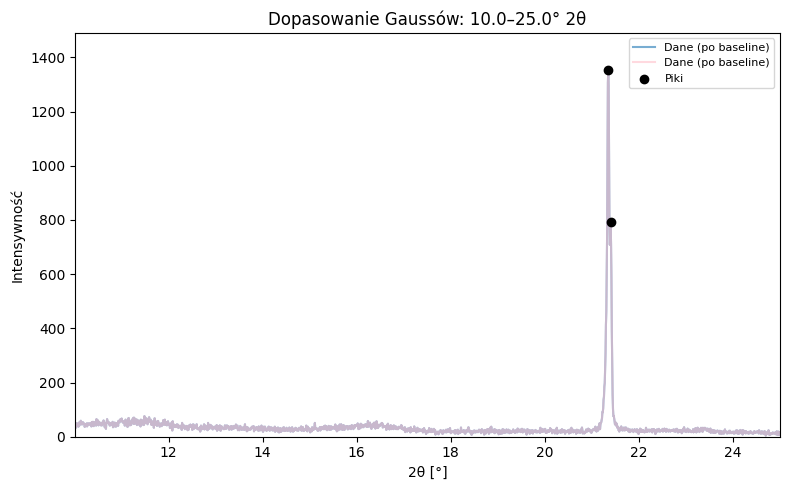

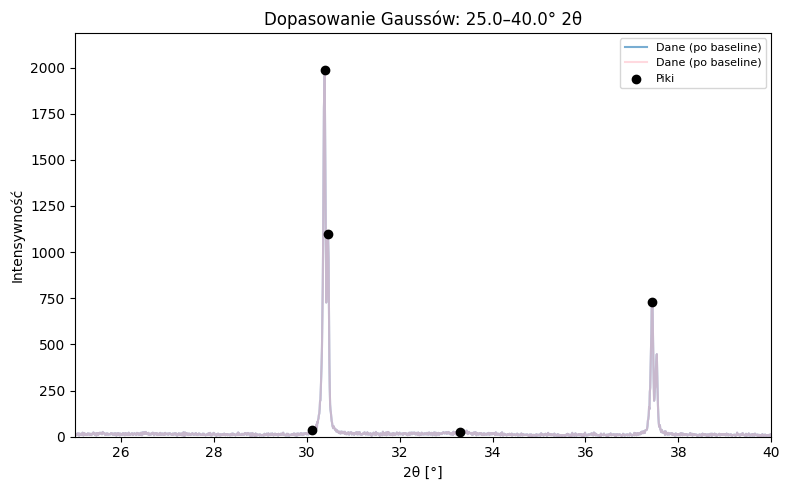

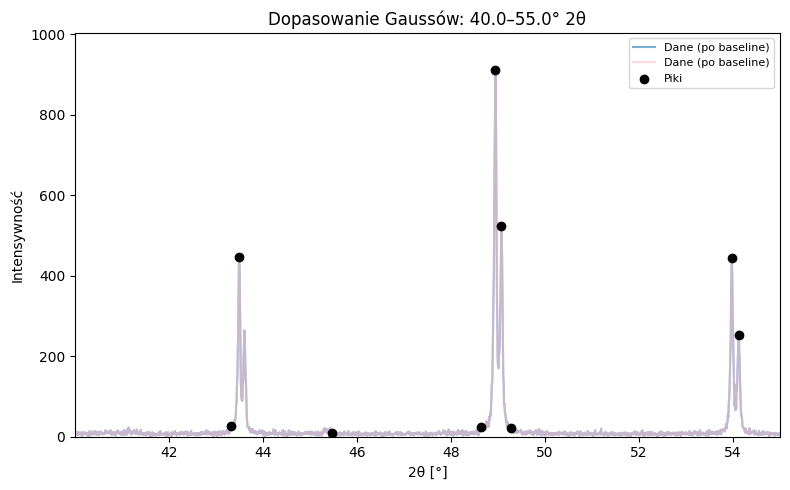

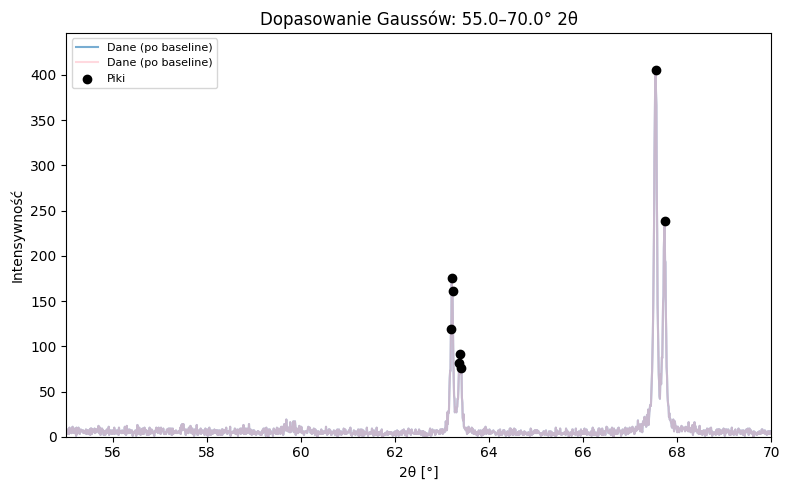

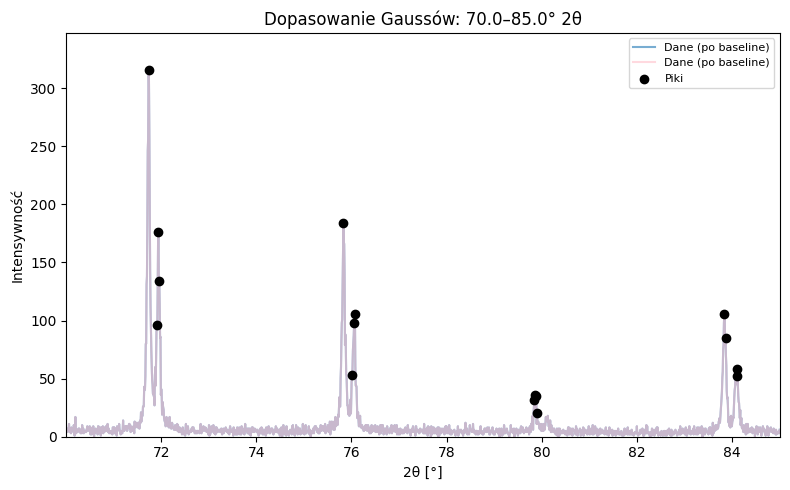

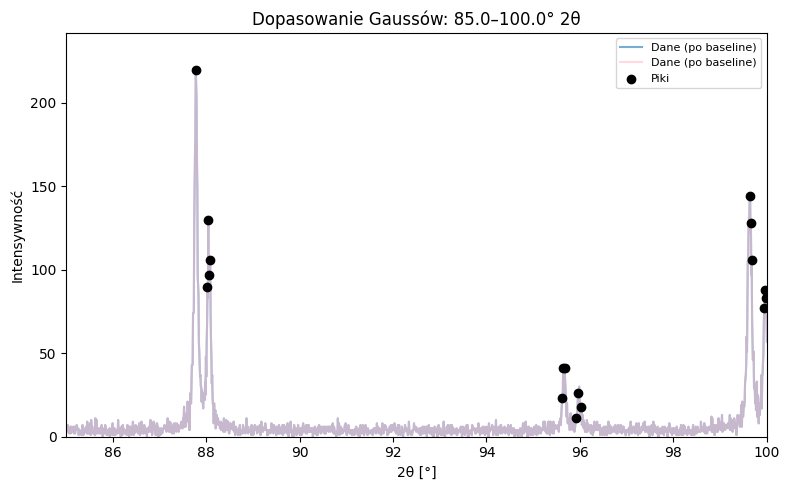

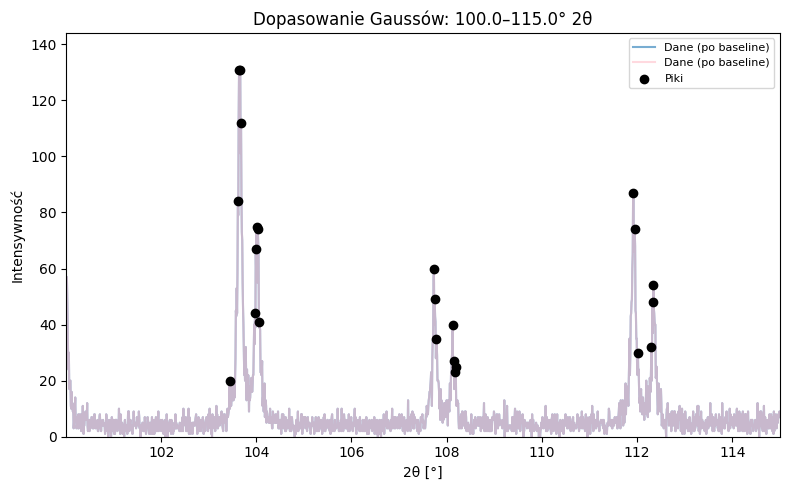

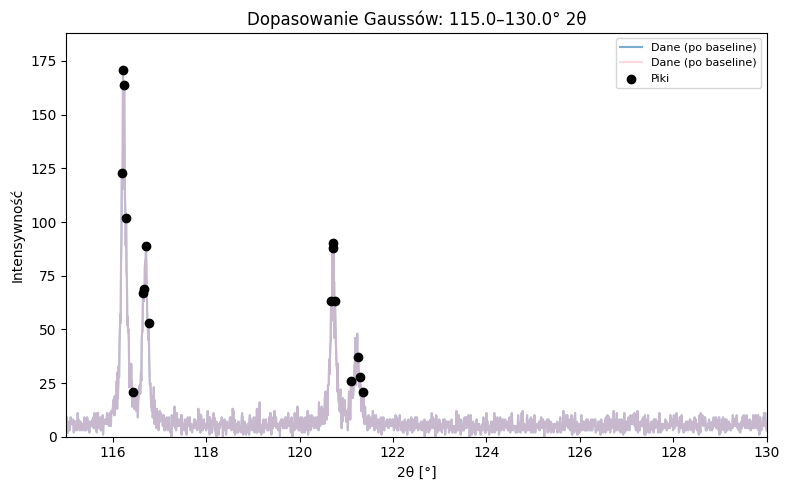

In [164]:
plot_gauss_ap(ap_good_peaks,ap.counts,ap.x)

In [165]:
import numpy as np

def finding_fwhm(peaks, gauss_fit):
    """
    Calculate FWHM and peak positions from Gaussian fit parameters.

    gauss_fit: array-like of shape (N, 3)
        Each row: [A, mu, sigma]
    """
    gauss_fit = np.asarray(gauss_fit)

    sigma = np.abs(gauss_fit[:, 2])
    mu = gauss_fit[:, 1]

    fwhm = 2 * sigma * np.sqrt(2 * np.log(2))
    t_fwhm = mu

    return fwhm, t_fwhm


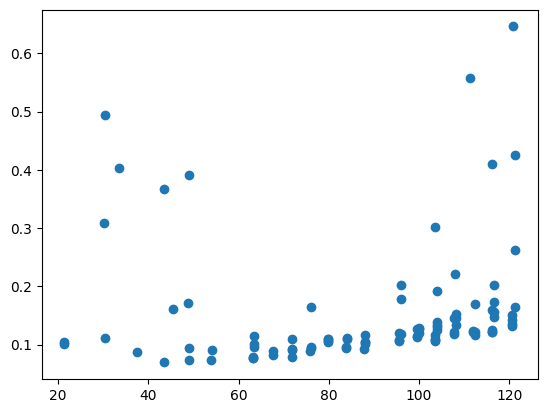

In [166]:
ap_fwhm,ap_t_fwhm = finding_fwhm(ap_good_peaks,ap_gauss_fit)
plt.scatter(ap_t_fwhm,ap_fwhm)


In [167]:
import numpy as np

def fit_poly_lower(x, y, x_min=60, q=0.2, deg=1):
    x = np.asarray(x)
    y = np.asarray(y)

    # odetnij początek
    mask = x >= x_min
    x0 = x[mask]
    y0 = y[mask]

    # zostaw tylko dolny kwantyl
    y_cut = np.quantile(y0, q)
    mask_q = y0 <= y_cut

    # polyfit
    coeffs = np.polyfit(x0[mask_q], y0[mask_q], deg)
    poly = np.poly1d(coeffs)

    y_fit = poly(x)
    y_fit[x < x_min] = np.nan

    return y_fit, poly


In [168]:
import numpy as np
from scipy.interpolate import UnivariateSpline

def fit_lower_trend_skip_start(x, y, x_min=None, bins=12, q=0.2, s=None):
    """
    Dopasowanie trendu do dolnej obwiedni z pominięciem początku.
    
    x_min : float lub None
        Jeśli podasz, punkty z x < x_min są ignorowane przy uczeniu.
    bins : int
        Liczba koszyków po osi X (im więcej, tym bardziej lokalnie).
    q : float
        Który dolny kwantyl brać w każdym koszyku (0.1–0.3 zwykle ok).
    s : float lub None
        Wygładzanie splajnu. None = auto (dobrze startuje).
        
    Returns:
        y_fit_all : np.ndarray  (dopasowane wartości dla wszystkich x)
        spline    : callable    (model, możesz wywołać spline(x_new))
        (xb, yb)  : punkty bazowe użyte do dopasowania (środki koszyków i kwantyle)
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # 1) pomiń początek
    mask = np.isfinite(x) & np.isfinite(y)
    if x_min is not None:
        mask &= (x >= x_min)

    x0 = x[mask]
    y0 = y[mask]

    if len(x0) < 5:
        raise ValueError("Za mało punktów po odcięciu x_min.")

    # 2) koszyki po X
    edges = np.linspace(x0.min(), x0.max(), bins + 1)
    xb, yb = [], []

    for i in range(bins):
        m = (x0 >= edges[i]) & (x0 < edges[i+1])
        if np.sum(m) < 3:
            continue
        xb.append(np.mean(x0[m]))
        yb.append(np.quantile(y0[m], q))

    xb = np.asarray(xb)
    yb = np.asarray(yb)

    if len(xb) < 4:
        raise ValueError("Za mało koszyków z danymi — zmniejsz bins albo x_min.")

    # 3) spline (wymaga rosnącego x)
    order = np.argsort(xb)
    xb, yb = xb[order], yb[order]

    spline = UnivariateSpline(xb, yb, s=s)
    y_fit_all = spline(x)

    return y_fit_all, spline, (xb, yb)


In [169]:
y_fit, poly = fit_poly_lower(ap_t_fwhm, ap_fwhm, x_min=0, q=0.2, deg=2)


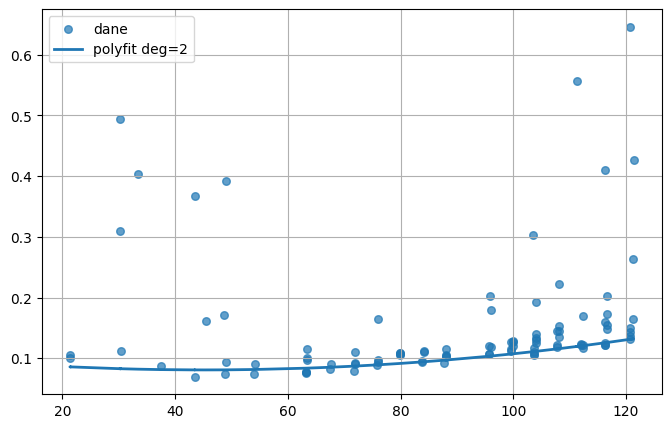

In [170]:
plt.figure(figsize=(8, 5))
plt.scatter(ap_t_fwhm, ap_fwhm, s=30, alpha=0.7, label="dane")
plt.plot(ap_t_fwhm, y_fit, linewidth=2, label=f"polyfit deg={poly.order}")
plt.legend()
plt.grid(True)
plt.show()

In [171]:
y_fit, model, (xb, yb) = fit_lower_trend_skip_start(
    ap_t_fwhm,ap_fwhm,
    x_min=60,     # <- tu tniesz początek
    bins=10,
    q=0.2,
    s=None
)


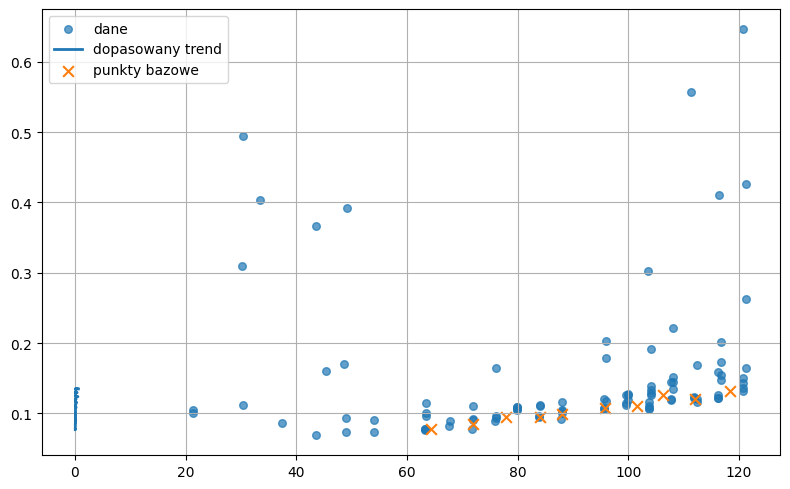

In [172]:


y_fit_plot = y_fit.copy()
y_fit_plot[ap_t_fwhm < 60] = np.nan

plt.figure(figsize=(8, 5))
plt.scatter(ap_t_fwhm, ap_fwhm, s=30, alpha=0.7, label="dane")
plt.plot(ap_fwhm, y_fit_plot, linewidth=2, label="dopasowany trend")
plt.scatter(xb, yb, marker="x", s=60, label="punkty bazowe")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Tworzę 7 wykresów (co 15° 2θ)...


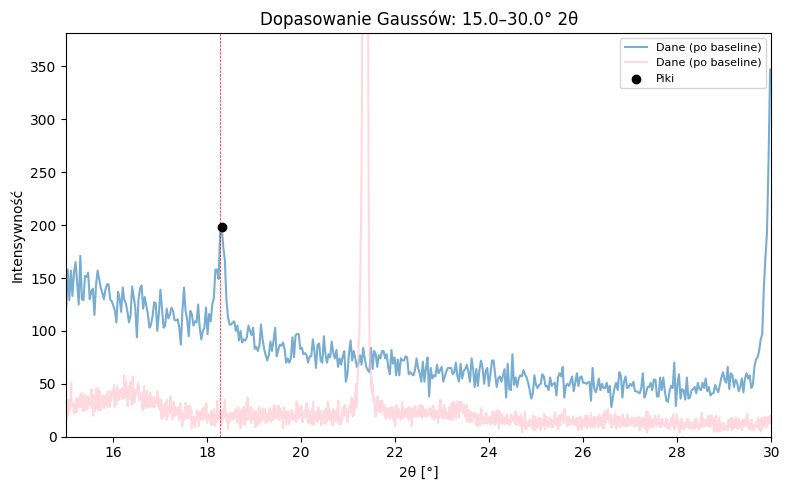

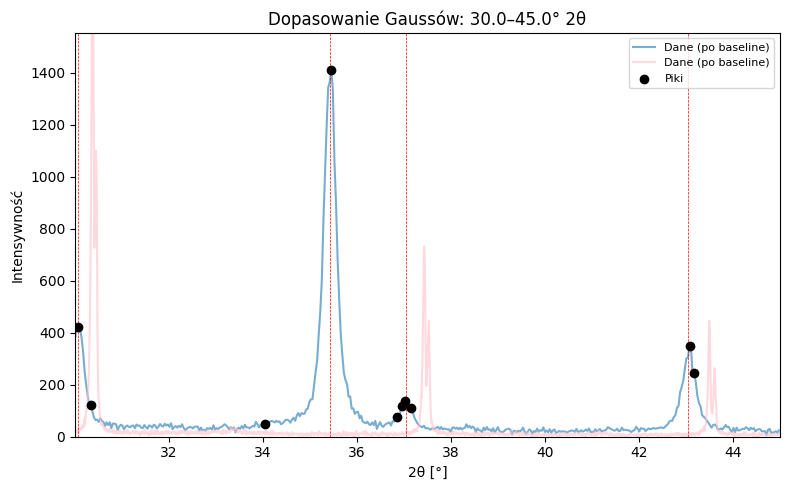

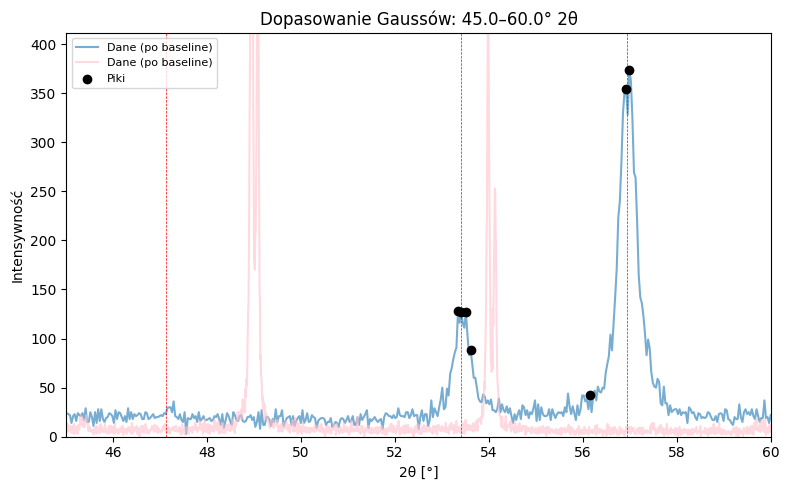

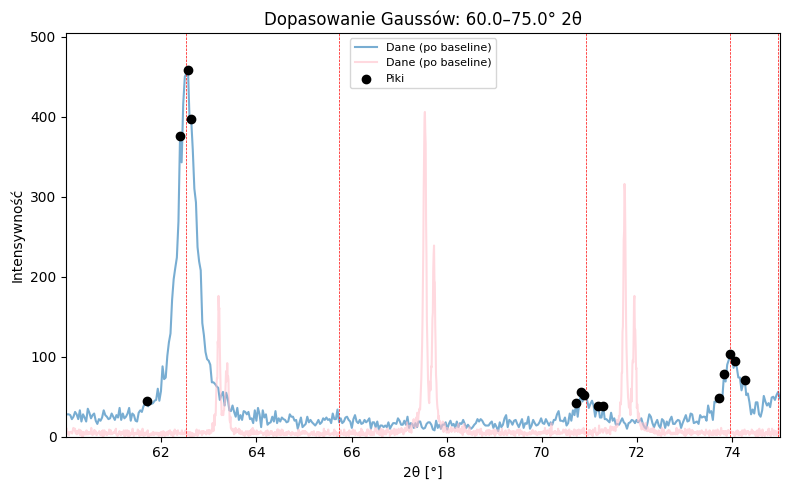

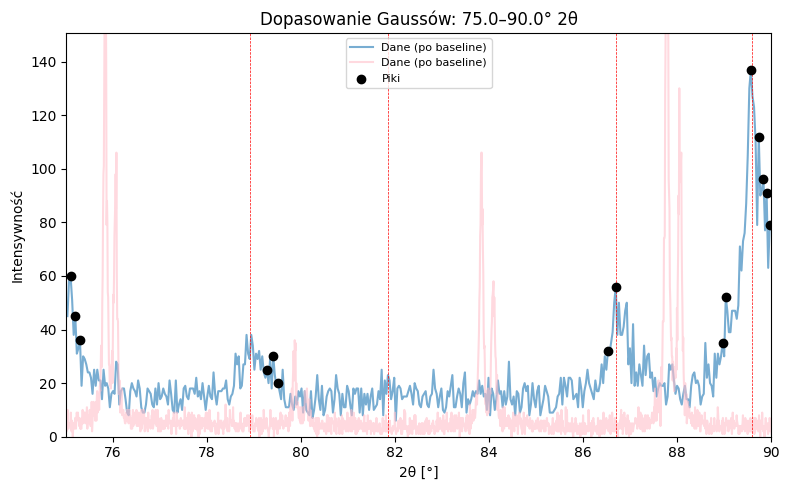

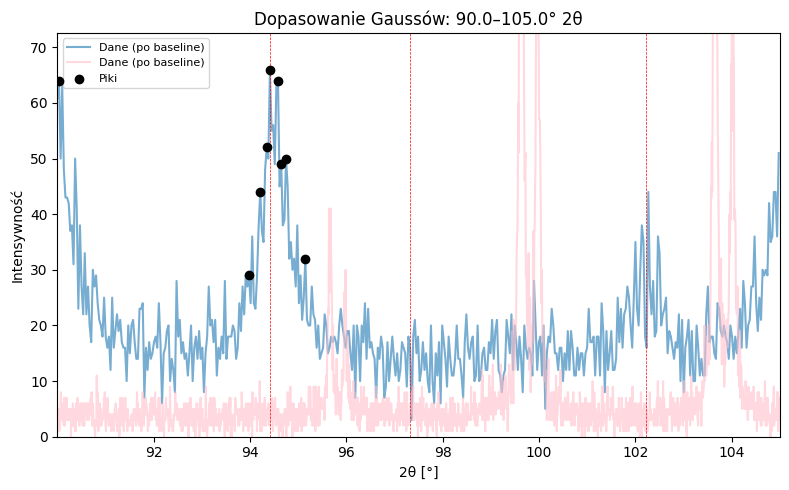

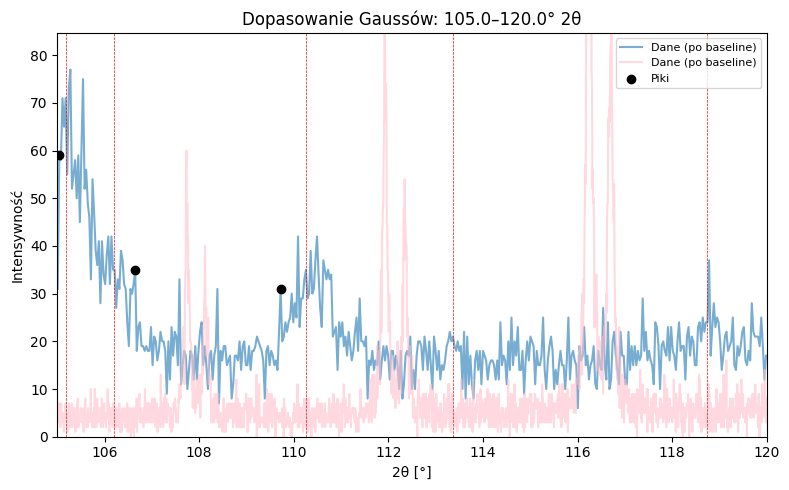

In [173]:
plot_gauss_ap(good_peaks,f.counts,f.x,two_theta=f.two_theta)

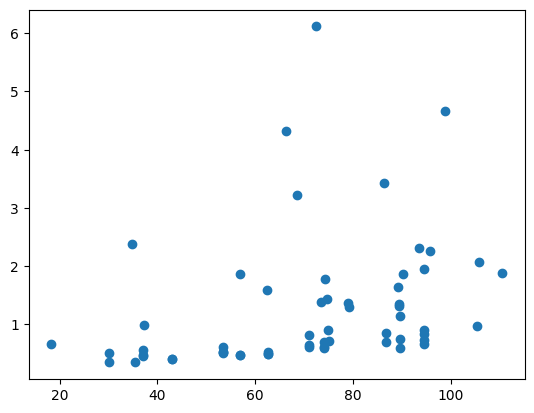

In [174]:
fwhm,t_fwhm = finding_fwhm(good_peaks,gauss_fit)
plt.scatter(t_fwhm,fwhm)
# plt.plot(ap.x,ap.counts)
# plt.plot(fwhm)

In [175]:
def peak_detect_safe(counts, min_points=5):
    if len(counts) < min_points:
        return np.array([])
    peaks, _ = find_peaks(counts)
    return peaks


In [176]:
def peak_detect_debug(counts, x):
    peaks, props = find_peaks(counts)
    print(f"Liczba pików: {len(peaks)}")

    for pk in peaks:
        print(f"pk={pk}, x={x[pk]:.2f}, I={counts[pk]:.1f}")

    return peaks


In [177]:
def fit_best_model(x, y):
    models = {
        "gauss": (gaussian, [max(y), x[np.argmax(y)], 1.0]),
        "lorentz": (lorentzian, [max(y), x[np.argmax(y)], 1.0]),
        "pv": (pseudo_voigt, [max(y), x[np.argmax(y)], 1.0, 1.0, 0.5])
    }

    best = {"r2": -np.inf}
    print(models.items())
    for name, (func, p0) in models.items():
        try:
            print(p0)
            popt, _ = curve_fit(func, x, y, p0=p0)
            # print(popt)
            # A, x0, sigma = popt
            if func == pseudo_voigt:
                r2 = rr2_pv(x, y, *popt)
            else:
                r2 = rr2(x, y,*popt)
            if r2 > best["r2"]:
                best = {"name": name, "popt": popt, "r2": r2}
        except RuntimeError:
            pass
        print(func)

    return best


In [178]:
best = fit_best_model(ap.x,ap.counts)
print(best)

dict_items([('gauss', (<function gaussian at 0x0000021B58F6ECA0>, [np.float64(1989.0), np.float64(30.383570446256527), 1.0])), ('lorentz', (<function lorentzian at 0x0000021B555E7C40>, [np.float64(1989.0), np.float64(30.383570446256527), 1.0])), ('pv', (<function pseudo_voigt at 0x0000021B555E79C0>, [np.float64(1989.0), np.float64(30.383570446256527), 1.0, 1.0, 0.5]))])
[np.float64(1989.0), np.float64(30.383570446256527), 1.0]
<function gaussian at 0x0000021B58F6ECA0>
[np.float64(1989.0), np.float64(30.383570446256527), 1.0]
<function lorentzian at 0x0000021B555E7C40>
[np.float64(1989.0), np.float64(30.383570446256527), 1.0, 1.0, 0.5]
<function pseudo_voigt at 0x0000021B555E79C0>
{'name': 'pv', 'popt': array([1.79308755e+03, 3.03827673e+01, 4.87648884e+01, 4.13458592e-02,
       9.87099410e-01]), 'r2': np.float64(0.4527334957976813)}


In [179]:
# p0 = []
# for pk in peaks:
#     p0 += [counts[pk], x[pk], 1.0]

# popt, _ = curve_fit(multi_gaussian, x, counts, p0=p0)


In [180]:
# popt, _ = curve_fit(
#     pseudo_voigt,
#     x_fit, y_fit,
#     p0=[A_guess, x0_guess, 1.0, 1.0, 0.5],
#     bounds=(
#         [0, x0_guess-5, 0.01, 0.01, 0],
#         [np.max(counts)*5, x0_guess+5, 10, 10, 1]
#     )
# )
